In [3]:
import geopandas as gpd 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import datetime as dt 
from shapely.geometry import Point, Polygon
import sys
import glob 
import os 
from scipy import stats 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import seaborn as sns
import copy

files_path = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/2015_04_to_2015_05"
read_files = glob.glob(os.path.join(files_path,"*.csv"))

li = []

for file in read_files: 
    df = pd.read_csv(file, index_col = None, header = 0)
    li.append(df)


files_path_census = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Census_data/Census_data_combined_boroughs"
read_files_census = glob.glob(os.path.join(files_path_census,"*.csv"))

li = []

for file in read_files_census: 
    df_census = pd.read_csv(file, index_col = None, header = 0)
    new_header = df_census.iloc[0]
    df_census = df_census[1:]
    df_census.columns = new_header
    df_census.reset_index(inplace=True, drop=True)
    li.append(df_census)

df_census = pd.concat(li, axis = 0, ignore_index = True)
df_census = df_census.drop(df_census.index[[26, 65]])
df_census = df_census.drop(df_census[df_census['Total!!Estimate!!Total population'] == '0'].index)
df = df.drop(df[df['end station name'] == 'South St & Gouverneur Ln'].index)

#files_path_census = "C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Census_data/Census_data_2018-2012_MANHATTAN/ACSST5Y2014.S0101_data_with_overlays_2020-02-02T201411.csv"
#df_census = pd.read_csv(files_path_census)

#new_header = df_census.iloc[0]
#df_census = df_census[1:]
#df_census.columns = new_header
#df_census.reset_index(inplace=True, drop=True)



C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
df["starttime"] = pd.to_datetime(df["starttime"], infer_datetime_format = True)
df["stoptime"] = pd.to_datetime(df["stoptime"], infer_datetime_format = True)
df["trip duration minutes"] = df["tripduration"]/60

df["user type number"] = 1
df.loc[df["usertype"] != "Subscriber", "user type number"] = 0

In [5]:
def get_distance(start_lat, start_long, end_lat, end_long): 
    radius = 6371 
    avg_lat = (start_lat + end_lat)/2 * (np.pi/180)
    delta_lat = (end_lat - start_lat) * (np.pi/180)
    delta_long = (end_long - start_long) * (np.pi/180)
    
    distance = radius*np.sqrt(delta_lat**2 + (np.cos(avg_lat)*delta_long)**2)
    return distance

df["age"] = 2015 - df["birth year"]

df["round trip"] = "yes"
df.loc[df["start station name"] != df["end station name"], "round trip"] = "no" 

df["distance traveled"] = get_distance(df["start station latitude"], 
                                       df["start station longitude"], 
                                       df["end station latitude"], 
                                       df["end station longitude"])


In [4]:
df["age"] = 2015 - df["birth year"]

In [5]:
df['geometry'] = df[['end station longitude', 'end station latitude']].apply(Point, axis=1)

In [6]:
df_zipbound = gpd.read_file('C:/Users/Michael Ip/TDI/Capstone_Project/citibike_tripdata/Boundaries_by_Zipcode/NYC_Zipcode_tabulation.json')

In [7]:
df_combined_end_station = gpd.sjoin(gpd.GeoDataFrame(df), df_zipbound, how='left', op= 'within')

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


<font size=5>DO NOT RUN THE NEXT CELL<font>

In [8]:
df_combined_end_station.to_csv('df_combined_2_end_station.csv', index=False)

<font size=5> Run the next line of code to load the necessary dataframes <font>

In [6]:
df_combined_census_total_end_station = pd.read_csv('df_combined_census_total_end_station.csv')
df_census_filtered_totals = pd.read_csv('df_census_filtered_totals.csv')

In [7]:
df_census_filtered = df_census.filter(regex = '(Total!!Estimate!!AGE|Total!!Estimate!!Total|Geographic Area Name)')

In [8]:
df_census_filtered['Geographic Area Name'] = df_census_filtered['Geographic Area Name'].map(lambda x: x.lstrip('ZCTA5'))
df_census_filtered.rename(columns={'Geographic Area Name':'postalCode'}, inplace=True)

C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Michael Ip\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [9]:
df_census_filtered = df_census_filtered.apply(pd.to_numeric)
temp1 = df_census_filtered[['postalCode', 'Total!!Estimate!!Total population']]
temp2 = df_census_filtered.loc[:,"Total!!Estimate!!AGE!!15 to 19 years":"Total!!Estimate!!AGE!!85 years and over"].multiply(df_census_filtered["Total!!Estimate!!Total population"]/100, axis=0)

df_census_filtered_totals = pd.concat([temp1, temp2], axis=1)
df_census_filtered_totals = df_census_filtered_totals.round(0)

In [10]:
df_census_filtered_totals.columns = df_census_filtered_totals.columns.str.lstrip('Total!!Estimate!!AGE!!')

In [11]:
pd.options.display.max_columns = None
df_combined_end_station['postalCode'] = df_combined_end_station['postalCode'].astype(int)
df_combined_census_total_end_station = df_combined_end_station.merge(df_census_filtered_totals, how='left', on='postalCode')


NameError: name 'df_combined_end_station' is not defined

In [17]:
df_combined_census_total_end_station.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip duration minutes,user type number,age,round trip,distance traveled,geometry,index_right,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id,population,15 to 19 years,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,5 to 9 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
0,415,2015-05-01 00:00:11,2015-05-01 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,-73.993915,17012,Subscriber,1981.0,1,6.916667,1,34.0,no,1.133461,POINT (-73.99392 40.74665),113,114,10001,New York,NY,Manhattan,36,061,0,19254.442129,1.779494e+07,http://nyc.pediacities.com/Resource/PostalCode...,23537.0,1059.0,2777.0,2636.0,2354.0,2260.0,1648.0,1483.0,1083.0,1318.0,1648.0,1036.0,1036.0,518.0,635.0,353.0,235.0
1,1523,2015-05-01 00:00:28,2015-05-01 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,17390,Customer,NaN,0,25.383333,0,NaN,no,4.566705,POINT (-73.98101 40.68989),140,141,11201,Brooklyn,NY,Brooklyn,36,047,0,41924.190131,4.109489e+07,http://nyc.pediacities.com/Resource/PostalCode...,58350.0,2334.0,3618.0,6418.0,8752.0,5893.0,4843.0,3676.0,2334.0,2976.0,2567.0,2567.0,1926.0,1750.0,934.0,992.0,1050.0
2,642,2015-05-01 00:00:52,2015-05-01 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,-73.979738,15003,Subscriber,1990.0,1,10.700000,1,25.0,no,2.035836,POINT (-73.97974 40.73913),118,119,10010,New York,NY,Manhattan,36,061,0,23512.593498,9.768395e+06,http://nyc.pediacities.com/Resource/PostalCode...,30708.0,1351.0,3316.0,4852.0,3224.0,2733.0,2242.0,1996.0,829.0,1535.0,1935.0,1474.0,1259.0,798.0,768.0,553.0,491.0
3,367,2015-05-01 00:00:48,2015-05-01 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,-73.995101,14788,Subscriber,1978.0,1,6.116667,1,37.0,no,1.206541,POINT (-73.99510 40.73332),121,122,10003,New York,NY,Manhattan,36,061,0,17396.136890,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...,57068.0,6163.0,6392.0,9131.0,6791.0,4337.0,3709.0,2625.0,742.0,3025.0,2910.0,2682.0,2340.0,1027.0,1141.0,742.0,742.0
4,2734,2015-05-01 00:00:51,2015-05-01 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,-74.016584,21068,Subscriber,1956.0,2,45.566667,1,59.0,no,0.375153,POINT (-74.01658 40.71534),261,262,10282,New York,NY,Manhattan,36,061,0,6083.869761,1.561955e+06,http://nyc.pediacities.com/Resource/PostalCode...,5730.0,69.0,97.0,378.0,905.0,842.0,676.0,332.0,424.0,309.0,46.0,74.0,92.0,17.0,17.0,46.0,115.0


<font size=5>DO NOT RUN NEXT CELL <font>

In [18]:
df_combined_census_total_end_station.to_csv('df_combined_census_total_end_station.csv', index=False)

In [12]:
df_combined_census_total_end_station = pd.read_csv('df_combined_census_total_end_station.csv')

In [13]:
df_census_numcols = copy.deepcopy(df_census_filtered_totals)

In [14]:
df_combined_census_numcols = copy.deepcopy(df_combined_census_total_end_station)

In [15]:
df_combined_census_numcols = df_combined_census_numcols.rename(columns = {'15 to 19 years' : 17, 
                       '20 to 24 years' : 22, 
                       '25 to 29 years' : 27, 
                       '30 to 34 years' : 32, 
                       '35 to 39 years' : 37,
                       '40 to 44 years' : 42, 
                       '45 to 49 years' : 47, 
                       '50 to 54 years' : 52, 
                       '55 to 59 years' : 57, 
                       '60 to 64 years' : 62, 
                       '65 to 69 years' : 67, 
                       '70 to 74 years' : 72, 
                       '75 to 79 years' : 77, 
                       '80 to 84 years' : 82, 
                       '85 years and over' : 87})
#df_combined_census_numcols = df_combined_census_numcols.drop(columns = ['Under 5 years', '5 to 9 years', '10 to 14 years'])

In [28]:
pd.options.display.max_columns=52
df_combined_census_numcols.head(10)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip duration minutes,user type number,age,round trip,distance traveled,geometry,index_right,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id,population,17,22,27,32,37,42,47,5 to 9 years,52,57,62,67,72,77,82,87
0,415,2015-05-01 00:00:11,2015-05-01 00:07:06,477,W 41 St & 8 Ave,40.756405,-73.990026,442,W 27 St & 7 Ave,40.746647,-73.993915,17012,Subscriber,1981.0,1,6.916667,1,34.0,no,1.133461,POINT (-73.993915 40.746647),113,114,10001,New York,NY,Manhattan,36,61,0,19254.442129,1.779494e+07,http://nyc.pediacities.com/Resource/PostalCode...,23537.0,1059.0,2777.0,2636.0,2354.0,2260.0,1648.0,1483.0,1083.0,1318.0,1648.0,1036.0,1036.0,518.0,635.0,353.0,235.0
1,1523,2015-05-01 00:00:28,2015-05-01 00:25:52,293,Lafayette St & E 8 St,40.730287,-73.990765,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,17390,Customer,NaN,0,25.383333,0,NaN,no,4.566705,POINT (-73.981013 40.689888),140,141,11201,Brooklyn,NY,Brooklyn,36,47,0,41924.190131,4.109489e+07,http://nyc.pediacities.com/Resource/PostalCode...,58350.0,2334.0,3618.0,6418.0,8752.0,5893.0,4843.0,3676.0,2334.0,2976.0,2567.0,2567.0,1926.0,1750.0,934.0,992.0,1050.0
2,642,2015-05-01 00:00:52,2015-05-01 00:11:35,380,W 4 St & 7 Ave S,40.734011,-74.002939,507,E 25 St & 2 Ave,40.739126,-73.979738,15003,Subscriber,1990.0,1,10.700000,1,25.0,no,2.035836,POINT (-73.97973776000001 40.73912601),118,119,10010,New York,NY,Manhattan,36,61,0,23512.593499,9.768395e+06,http://nyc.pediacities.com/Resource/PostalCode...,30708.0,1351.0,3316.0,4852.0,3224.0,2733.0,2242.0,1996.0,829.0,1535.0,1935.0,1474.0,1259.0,798.0,768.0,553.0,491.0
3,367,2015-05-01 00:00:48,2015-05-01 00:06:55,537,Lexington Ave & E 24 St,40.740259,-73.984092,280,E 10 St & 5 Ave,40.733320,-73.995101,14788,Subscriber,1978.0,1,6.116667,1,37.0,no,1.206541,POINT (-73.99510132 40.73331967),121,122,10003,New York,NY,Manhattan,36,61,0,17396.136890,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...,57068.0,6163.0,6392.0,9131.0,6791.0,4337.0,3709.0,2625.0,742.0,3025.0,2910.0,2682.0,2340.0,1027.0,1141.0,742.0,742.0
4,2734,2015-05-01 00:00:51,2015-05-01 00:46:26,426,West St & Chambers St,40.717548,-74.013221,327,Vesey Pl & River Terrace,40.715338,-74.016584,21068,Subscriber,1956.0,2,45.566667,1,59.0,no,0.375153,POINT (-74.01658354 40.71533789999999),261,262,10282,New York,NY,Manhattan,36,61,0,6083.869761,1.561955e+06,http://nyc.pediacities.com/Resource/PostalCode...,5730.0,69.0,97.0,378.0,905.0,842.0,676.0,332.0,424.0,309.0,46.0,74.0,92.0,17.0,17.0,46.0,115.0
5,359,2015-05-01 00:01:07,2015-05-01 00:07:07,439,E 4 St & 2 Ave,40.726281,-73.989780,302,Avenue D & E 3 St,40.720828,-73.977932,17406,Subscriber,1961.0,1,5.983333,1,54.0,no,1.168148,POINT (-73.97793172 40.72082834),125,126,10009,New York,NY,Manhattan,36,61,0,16247.124264,1.590352e+07,http://nyc.pediacities.com/Resource/PostalCode...,61806.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,1854.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
6,236,2015-05-01 00:01:05,2015-05-01 00:05:02,401,Allen St & Rivington St,40.720196,-73.989978,438,St Marks Pl & 1 Ave,40.727791,-73.985649,15005,Subscriber,1971.0,1,3.933333,1,44.0,no,0.919994,POINT (-73.98564945 40.72779126),121,122,10003,New York,NY,Manhattan,36,61,0,17396.136890,1.553838e+07,http://nyc.pediacities.com/Resource/PostalCode...,57068.0,6163.0,6392.0,9131.0,6791.0,4337.0,3709.0,2625.0,742.0,3025.0,2910.0,2682.0,2340.0,1027.0,1141.0,742.0,742.0
7,1991,2015-05-01 00:01:16,2015-05-01 00:34:28,532,S 5 Pl & S 4 St,40.710451,-73.960876,529,W 42 St & 8 Ave,40.757570,-73.990985,15566,Subscriber,1993.0,1,33.183333,1,22.0,no,5.821262,POINT (-73.99098506999999 40.75756989999999),105,106,10036,New York,NY,Manhattan,36,61,0,16418.606668,1.139511e+07,http://nyc.pediaciti

In [16]:
#The following start stations were dropped because there were no proper zipcodes attached to them 

indexNames = df_combined_census_numcols[(df_combined_census_numcols['end station name'] == 'Central Park S & 6 Ave')| 
                                        (df_combined_census_numcols['end station name'] == 'Clinton Ave & Flushing Ave')|
                                        (df_combined_census_numcols['end station name'] == 'Sands St & Navy St')|
                                        (df_combined_census_numcols['end station name'] == 'Railroad Ave & Kay Ave')].index
df_combined_census_numcols.drop(indexNames, inplace=True)

In [17]:
end_stations = df_combined_census_numcols.groupby(df_combined_census_numcols['end station name'])

In [18]:
indiv_station_dict = dict()
for end_station, frame in end_stations: 
    indiv_station_dict[end_station] = pd.DataFrame(frame[['age', 17, 22, 27, 32, 37, 42, 47, 
                                                            52, 57, 62, 67, 72, 77, 82, 87]]).dropna()

In [34]:
indiv_station_dict['1 Ave & E 15 St']

,age,17,22,27,32,37,42,47,52,57,62,67,72,77,82,87
66,30.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
274,23.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
280,26.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
369,56.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
409,66.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964738,28.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
964813,32.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
964947,26.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0
965240,39.0,2410.0,6922.0,8715.0,6490.0,4388.0,3338.0,4017.0,4141.0,3894.0,3956.0,2472.0,2472.0,1298.0,1051.0,989.0


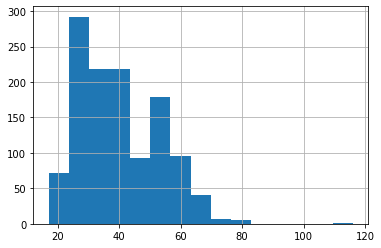

In [49]:
indiv_station_dict['Catherine St & Monroe St']['age'].hist(bins= 15)

In [19]:
bool_series = pd.isnull(df_combined_census_numcols[" population"])
df_combined_census_numcols[bool_series] 

df_combined_census_numcols[df_combined_census_numcols[' population'].isnull()]['end station name'].unique()

#np.where(pd.isnull(df_combined_census_numcols))

array([], dtype=object)

In [38]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

test = indiv_station_dict['10 Ave & W 28 St']['age'].apply(lambda x: custom_round(x, base=5))

test.value_counts().max()


717

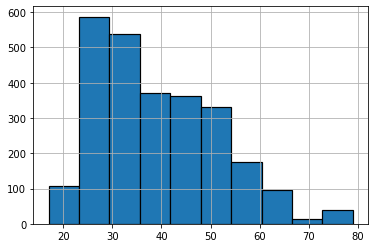

In [33]:
indiv_station_dict['W 29 St & 9 Ave']['age'].hist(
    bins = 10, linewidth=1.2, edgecolor='black')

In [41]:
indiv_station_dict['8 Ave & W 52 St']['age'].apply(lambda x: custom_round(x, base=5)).value_counts()

30     354
40     232
35     223
45     197
25     197
50     171
55     144
60      83
65      31
20       9
75       4
70       3
130      1
115      1
15       1
Name: age, dtype: int64

In [43]:
indiv_station_dict['8 Ave & W 52 St'].loc[indiv_station_dict['8 Ave & W 52 St'].first_valid_index(), 
                                           [17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87]]

17     659.0
22    2131.0
27    5890.0
32    5077.0
37    3526.0
42    3061.0
47    3100.0
52    2209.0
57    2906.0
62    2131.0
67    1628.0
72    1356.0
77    1124.0
82     853.0
87     775.0
Name: 1119, dtype: float64

In [33]:
import altair as alt 
alt.data_transformers.enable('default', max_rows=None)
vis = []

for station, frame in indiv_station_dict.items(): 
    chart = alt.Chart(pd.DataFrame(frame['age'])).mark_bar().encode(
        alt.X('age', bin=alt.Bin(extent=[18, 90], step=5)), 
        y='count()').properties(width=450, height=250, title='{}'.format(station))
    
    max_biker_counts = frame['age'].apply(lambda x: custom_round(x, base=5)).value_counts().max()
    max_census_counts = frame.loc[frame.first_valid_index(), 
    [17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87]].max()
    ratio = max_census_counts/max_biker_counts
    
    data = frame.loc[
    frame.first_valid_index(), 
    [17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87]]
    data = pd.DataFrame(data)
    data = data.rename(columns={frame.first_valid_index():'value'})
    data.reset_index(level=0, inplace=True)
    data['value'] = data['value']/ratio 
    
    bar_filled = (alt.Chart(data).mark_area(color='red', interpolate='monotone', fillOpacity=0.2).encode(
    alt.X("index:Q"),
    alt.Y("value:Q")))
          
    overlay = alt.layer(chart, bar_filled)
    vis.append(overlay.to_json())

1 Ave & E 15 St          age      17      22      27      32      37      42      47      52  \
66      30.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
274     23.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
280     26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
369     56.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
409     66.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964738  28.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964813  32.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964947  26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965240  39.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965385  26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   

            57      62 

11 Ave & W 41 St          age     17      22      27      32      37      42      47      52  \
382     27.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
596     51.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
890     44.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
1392    51.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
1568    41.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
965160  51.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
965293  27.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
965297  30.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
965319  38.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
965426  28.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   

            57      62      67    

6 Ave & Broome St          age      17      22      27      32      37      42      47      52  \
91      45.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
1480    39.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
1672    42.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
2105    41.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
2452    40.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963519  30.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
963841  52.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
965059  29.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
965092  29.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   
965254  25.0  1077.0  2559.0  2801.0  2667.0  2020.0  2101.0  1589.0  1293.0   

            57      6

9 Ave & W 14 St          age     17      22      27      32      37      42      47      52  \
261     32.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
367     47.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
845     41.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
1031    28.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
2767    47.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
962688  44.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
963026  38.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
963327  56.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
964054  29.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
964635  29.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   

            57      62      67     

Allen St & Hester St          age      17      22      27      32      37      42      47      52  \
86      28.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
174     25.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
316     35.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
422     41.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
568     36.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964939  38.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965183  39.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965209  26.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965218  25.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965337  26.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            57    

Avenue D & E 12 St          age      17      22      27      32      37      42      47      52  \
175     27.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
4570    29.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
11163   26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
13392   40.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
18622   45.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
956941  35.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
960597  63.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
961050  64.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
962439  47.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
962984  38.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   

            57      

Barrow St & Hudson St          age     17      22      27      32      37      42      47      52  \
265     29.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
560     41.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
1447    28.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
1662    56.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
1676    34.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
965120  30.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
965153  30.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
965197  30.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
965237  52.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
965338  23.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   

            57      62      6

Broad St & Bridge St          age     17     22     27     32     37     42     47     52     57  \
726     39.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
733     49.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
838     36.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
1109    42.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
1537    39.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
954829  30.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
955305  28.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
958306  41.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
961204  47.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
964464  29.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   

           62     67    72    

Broadway & W 24 St          age      17      22      27      32      37      42      47      52  \
346     35.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
421     48.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
438     48.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
786     41.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
791     45.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964741  59.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
964799  29.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
965122  29.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
965288  39.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   
965369  26.0  1351.0  3316.0  4852.0  3224.0  2733.0  2242.0  1996.0  1535.0   

            57      

Broadway & W 49 St          age     17      22      27      32      37      42      47      52  \
532     34.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
598     52.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
656     34.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
804     24.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
832     36.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
887644  28.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
888516  58.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
888544  42.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
888793  58.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
889018  42.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   

            57      62      67  

Broadway & W 60 St          age      17      22      27      32      37      42      47      52  \
29      45.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
53      35.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
547     50.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
552     41.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
559     55.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963624  31.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
963789  19.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
964623  37.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
964691  43.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   
965141  45.0  1641.0  2309.0  5955.0  5408.0  5529.0  4618.0  4314.0  3950.0   

            57      

Canal St & Rutgers St          age      17      22      27      32      37      42      47      52  \
375     44.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
385     40.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
387     22.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
429     30.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
823     42.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964855  31.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965032  32.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965332  30.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965356  26.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965424  33.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            57   

[1566 rows x 16 columns]
Cherry St          age      17      22      27      32      37      42      47      52  \
5133    41.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
5830    62.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
6961    59.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
8170    57.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
8790    37.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963220  17.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
963570  45.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
963736  38.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964027  35.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965013  42.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

    

Cleveland Pl & Spring St          age     17      22      27      32      37      42      47      52  \
42      36.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
114     20.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
512     49.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
538     34.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
834     33.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
964720  24.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964773  30.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964919  37.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964973  50.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
965027  49.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   

            57      62    

Clinton St & Tillary St          age      17      22      27      32      37      42      47      52  \
457     40.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
6316    23.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
7772    44.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
8218    44.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
10777   44.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
957259  48.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
957277  55.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965038  30.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965339  44.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965381  20.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            57 

DeKalb Ave & S Portland Ave          age      17      22      27      32      37      42      47      52  \
1697    45.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
3542    25.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
5604    39.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
9477    41.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
10454   37.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963191  20.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
963837  34.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
964723  73.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965152  46.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965205  32.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

           

E 10 St & 5 Ave          age      17      22      27      32      37      42      47      52  \
3       37.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
219     39.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
637     36.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1468    40.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1712    30.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964853  61.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964922  30.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
965071  31.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
965142  63.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
965143  64.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   

            57      62 

E 13 St & Avenue A          age      17      22      27      32      37      42      47      52  \
80      40.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
81      26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
249     30.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
267     26.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
292     28.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964652  52.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964688  42.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964895  25.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964993  28.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965245  23.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   

            57      

E 19 St & 3 Ave          age      17      22      27      32      37      42      47      52  \
31      26.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
295     61.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1215    28.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
2129    48.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
2177    28.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
962666  55.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
962673  24.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
963000  38.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
963933  54.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964162  40.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   

            57      62 

E 20 St & FDR Drive          age      17      22      27      32      37      42      47      52  \
272     45.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
313     24.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
1318    47.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
1351    39.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
2079    22.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964471  30.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964807  33.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964955  31.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965015  25.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965184  21.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   

            57     

E 27 St & 1 Ave          age      17      22      27      32      37      42      47      52  \
473     56.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
530     24.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
610     28.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
879     46.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
894     37.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963854  27.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964038  48.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964260  29.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964779  40.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
965378  40.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   

            57      62 

E 33 St & 5 Ave          age      17      22      27      32      37      42      47      52  \
1226    51.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
1613    54.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
1681    52.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
1991    26.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
2419    45.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963141  45.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964082  30.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964083  27.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
964229  25.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
965303  37.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   

            57      62 

E 40 St & 5 Ave          age      17      22      27      32      37      42      47      52  \
305     52.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
488     38.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
491     50.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
1304    41.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
1364    26.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
961341  34.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
962002  29.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
962082  49.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
962827  35.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   
965388  52.0  1203.0  5312.0  9722.0  6815.0  3558.0  2756.0  2506.0  2957.0   

            57      62 

E 47 St & Park Ave          age     17      22      27      32      37      42     47      52  \
487     51.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
533     55.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
651     57.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
696     54.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
730     50.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
...      ...    ...     ...     ...     ...     ...     ...    ...     ...   
959655  29.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
961089  30.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
961347  24.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
964695  30.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
964995  24.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   

           57     62     67     72     77   

E 51 St & Lexington Ave          age     17      22      27      32      37      42      47      52  \
195     61.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
513     31.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
699     50.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1173    40.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1397    50.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
958298  24.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
959313  39.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
960762  26.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
961243  46.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
961640  29.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   

            57      62     

E 56 St & 3 Ave          age     17      22      27      32      37      42      47      52  \
1252    49.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1266    38.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1523    54.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1525    46.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
1563    42.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
961015  34.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
963548  45.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
964169  66.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
964788  27.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   
965101  24.0  505.0  1574.0  3207.0  2703.0  2138.0  2049.0  1693.0  1812.0   

            57      62      67     

[1426 rows x 16 columns]
E 7 St & Avenue A          age      17      22      27      32      37      42      47      52  \
37      46.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
102     29.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
157     23.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
158     24.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
180     39.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964752  50.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964785  32.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
964989  38.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965241  34.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0   
965261  25.0  2410.0  6922.0  8715.0  6490.0  4388.0  3338.0  4017.0  4141.0 

Forsyth St & Broome St          age      17      22      27      32      37      42      47      52  \
152     34.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
220     35.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
328     47.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
379     61.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
397     59.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964700  40.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964833  28.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964896  45.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965083  48.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965135  41.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            57  

Front St & Maiden Ln          age    17     22      27      32     37     42     47     52    57  \
531     63.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
810     45.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
1039    37.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
1123    28.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
1196    34.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
...      ...   ...    ...     ...     ...    ...    ...    ...    ...   ...   
961708  30.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
961817  51.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
962153  31.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
962763  43.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
965043  57.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   

          62    67    72   77 

Gallatin Pl & Livingston St          age      17      22      27      32      37      42      47      52  \
207     55.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
5279    34.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
8339    44.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
10267   27.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
10552   36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
955379  42.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
957193  25.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
957755  32.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
960384  45.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
963276  45.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

           

Greenwich Ave & 8 Ave          age     17      22      27      32      37      42      47      52  \
217     24.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
296     30.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
396     30.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
490     35.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
537     32.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
964461  24.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
964513  36.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
964661  59.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
964876  39.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   
965075  28.0  541.0  1369.0  5539.0  4489.0  2961.0  2388.0  2228.0  2133.0   

            57      62      6

Henry St & Atlantic Ave          age      17      22      27      32      37      42      47      52  \
117     26.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1442    48.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2144    56.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
8030    36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
8867    60.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
961434  57.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961508  50.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961647  49.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
963875  40.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
964593  35.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            57 

Jay St & Tech Pl          age      17      22      27      32      37      42      47      52  \
994     56.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1948    45.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2332    52.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2375    17.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2523    21.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
944179  36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
946205  34.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
955508  25.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
959845  31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
962788  61.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            57      62

Lafayette Ave & Classon Ave          age      17      22      27      32      37      42      47      52  \
337     30.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
828     48.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
4878    33.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
5622    28.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
6540    28.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
959604  28.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
960227  59.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
961923  33.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
962081  27.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   
962609  36.0  2686.0  4938.0  4332.0  4505.0  3899.0  2729.0  1993.0  1949.0   

           

Lawrence St & Willoughby St          age      17      22      27      32      37      42      47      52  \
393     33.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
404     23.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
640     51.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1160    32.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2555    43.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
959644  23.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
960345  33.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961017  30.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961504  31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
965403  51.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

           

Liberty St & Broadway          age    17     22      27      32     37     42     47     52    57  \
356     62.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
600     57.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
673     52.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
1096    48.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
1105    60.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
...      ...   ...    ...     ...     ...    ...    ...    ...    ...   ...   
962462  31.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
963036  57.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
963436  32.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
963688  49.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   
965414  51.0  15.0  999.0  2702.0  1173.0  712.0  636.0  371.0  167.0  83.0   

          62    67    72   77

Madison St & Montgomery St          age      17      22      27      32      37      42      47      52  \
132677  43.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
133325  32.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
133513  50.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
137294  55.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
137445  35.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
962932  34.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
963515  32.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964937  33.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965084  49.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965194  26.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            

Metropolitan Ave & Bedford Ave          age      17      22       27       32      37      42      47  \
2388    38.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
3292    34.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
3486    27.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
3716    29.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
4133    37.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
...      ...     ...     ...      ...      ...     ...     ...     ...   
961674  50.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
961707  39.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
962411  35.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
964033  31.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   
964809  31.0  4734.0  7764.0  14013.0  11551.0  7669.0  5113.0  4450.0   

            52      57      62      67      72      77      82      87  
2388   

Myrtle Ave & St Edwards St          age      17      22      27      32      37      42      47      52  \
1001    27.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
7058    23.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
9957    55.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
11604   46.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
12654   46.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
951809  53.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
951896  27.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
953322  31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
958038  38.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961407  35.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            

Pearl St & Anchorage Pl          age      17      22      27      32      37      42      47      52  \
49      48.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1755    36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2402    26.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2754    43.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
3214    36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
959209  35.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
959308  36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
959318  28.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
959986  40.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
961981  30.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            57 

Pershing Square South          age     17      22      27      32      37      42     47      52  \
621     53.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
650     60.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
792     26.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
1402    45.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
1543    59.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
...      ...    ...     ...     ...     ...     ...     ...    ...     ...   
950121  61.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
953535  59.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
953951  71.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
955132  31.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   
958546  66.0  181.0  1153.0  2981.0  2240.0  1334.0  1153.0  791.0  1219.0   

           57     62     67     72     77

Rivington St & Ridge St          age      17      22      27      32      37      42      47      52  \
270     49.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
2191    41.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
3626    37.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
12314   43.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
12424   23.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964529  56.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964537  25.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964557  32.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965094  22.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
965359  31.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            57 

South St & Whitehall St          age     17     22     27     32     37     42     47     52     57  \
811     37.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
1415    47.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
1893    42.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
2013    53.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
2389    53.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
956209  27.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
958372  34.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
958683  31.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
960492  57.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   
960533  57.0  163.0  281.0  420.0  442.0  269.0  233.0  209.0  194.0  112.0   

           62     67    72 

Stanton St & Chrystie St          age      17      22      27      32      37      42      47      52  \
191     27.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
3200    43.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
3311    35.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
4353    51.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
4372    55.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964521  55.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964617  33.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964812  30.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964862  30.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   
964952  27.0  3915.0  5193.0  6951.0  6791.0  6072.0  5672.0  5912.0  5353.0   

            57

University Pl & E 14 St          age      17      22      27      32      37      42      47      52  \
63      24.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
534     28.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1072    57.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1114    28.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1149    31.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964630  61.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964899  28.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964943  32.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964963  39.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
965273  25.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   

            57 

W 13 St & 7 Ave          age      17      22      27      32      37      42      47      52  \
613     26.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
1037    37.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
1111    27.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
1282    52.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
1482    45.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963791  33.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
964535  41.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
964839  39.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
965049  43.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
965060  46.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   

            57      62 

W 20 St & 7 Ave          age      17      22      27      32      37      42      47      52  \
154     39.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
435     31.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
526     53.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
543     33.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
987     27.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964532  53.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
964753  48.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
964898  44.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
965029  26.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   
965139  51.0  1482.0  2912.0  5982.0  7253.0  4606.0  5612.0  4076.0  3229.0   

            57      62 

W 24 St & 7 Ave          age      17      22      27      32      37      42      47      52  \
68      54.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
374     33.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
564     29.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
573     44.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
870     42.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
964510  45.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
964749  49.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
964988  33.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
965250  51.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
965313  40.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   

            57      62 

W 31 St & 7 Ave          age      17      22      27      32      37      42      47      52  \
19      34.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
434     53.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
799     53.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
1135    46.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
1165    28.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
961248  22.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
962394  25.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
963274  47.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
963426  43.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   
963528  52.0  1059.0  2777.0  2636.0  2354.0  2260.0  1648.0  1483.0  1318.0   

            57      62 

W 38 St & 8 Ave          age     17      22      27      32     37     42     47     52  \
28      39.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
424     29.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
441     33.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
525     34.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
772     47.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
...      ...    ...     ...     ...     ...    ...    ...    ...    ...   
962261  39.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
963612  59.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
963614  32.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
964425  56.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   
965263  29.0  211.0  1045.0  2411.0  1595.0  999.0  504.0  468.0  403.0   

           57     62     67    72    77   82   87  
28      385.0  248.0  183.0  37

W 43 St & 6 Ave          age     17      22      27      32      37      42      47      52  \
378     36.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
755     35.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
771     40.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
1220    32.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
1376    45.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
415650  41.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
415808  30.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
416063  30.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
416144  37.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   
416677  65.0  531.0  2340.0  3788.0  3233.0  2003.0  2316.0  1665.0  1737.0   

            57      62      67     

W 49 St & 8 Ave          age     17      22      27      32      37      42      47      52  \
325     37.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
556     32.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
585     37.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
612     49.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
1101    43.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
639899  56.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
640538  41.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
641118  34.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
641151  41.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
641664  39.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   

            57      62      67     

W 53 St & 10 Ave          age     17      22      27      32      37      42      47      52  \
332     28.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
623     25.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
1065    37.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
1494    30.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
1620    46.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
964046  29.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
964307  34.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
964378  33.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
965007  39.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   
965422  31.0  659.0  2131.0  5890.0  5077.0  3526.0  3061.0  3100.0  2209.0   

            57      62      67    

W Broadway & Spring St          age     17      22      27      32      37      42      47      52  \
36      46.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
131     33.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
1462    24.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
1488    33.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
2950    27.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
...      ...    ...     ...     ...     ...     ...     ...     ...     ...   
964718  63.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964758  28.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964846  36.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
964883  62.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   
965204  41.0  571.0  2659.0  4348.0  3230.0  1963.0  1466.0  1217.0  1416.0   

            57      62      

Warren St & Church St          age     17     22     27      32     37     42     47     52     57  \
173     51.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
500     35.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
575     33.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
831     44.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
897     50.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
...      ...    ...    ...    ...     ...    ...    ...    ...    ...    ...   
963227  32.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
963473  39.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
963667  29.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
964399  33.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   
964687  27.0  256.0  283.0  776.0  1019.0  769.0  810.0  547.0  412.0  223.0   

           62    

Washington Square E          age      17      22      27      32      37      42      47      52  \
167     32.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1121    22.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
1492    58.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
3233    19.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
3986    44.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
962279  44.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
962404  57.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
962699  33.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
963581  25.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   
964865  53.0  6163.0  6392.0  9131.0  6791.0  4337.0  3709.0  2625.0  3025.0   

            57     

West Thames St          age     17     22     27      32      37     42     47     52     57  \
35      27.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
284     27.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
1197    64.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
1701    57.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
2055    31.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
...      ...    ...    ...    ...     ...     ...    ...    ...    ...    ...   
964522  65.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
964707  49.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
964805  62.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
965078  30.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   
965110  31.0  210.0  363.0  736.0  1395.0  1204.0  764.0  583.0  850.0  573.0   

           6

York St & Jay St          age      17      22      27      32      37      42      47      52  \
454     31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1539    31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1717    36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
1947    36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
2073    39.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
963479  48.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
963673  36.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
964641  31.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
964768  32.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   
964804  32.0  2334.0  3618.0  6418.0  8752.0  5893.0  4843.0  3676.0  2976.0   

            57      62

In [16]:
df["age"] = 2015 - df["birth year"]

In [120]:
stations = df.take([8,9,10], axis=1)
#stations = df.take([4,5,6], axis=1).loc[['start station name']]
stations = stations.drop_duplicates().reset_index(drop=True)

age_bin = np.linspace(31, 44, 14)
groups = df.groupby(by = "end station name")["age"].agg(["mean"]).reset_index()
groups = groups.rename(columns = {"mean" : "mean age"})
groups["age bins"] = pd.cut(x = groups["mean age"], bins = age_bin)

stations = pd.merge(groups, stations, how='outer', on = 'end station name')


quantile_age_0 = stations["mean age"].quantile(0)
quantile_age_10 = stations["mean age"].quantile(0.10)
quantile_age_25 = stations["mean age"].quantile(0.25)
quantile_age_50 = stations["mean age"].quantile(0.50)
quantile_age_75 = stations["mean age"].quantile(0.75)
quantile_age_90 = stations["mean age"].quantile(0.90)
quantile_age_1 = stations["mean age"].quantile(1)

def colorfunc_age(row): 
    if row["mean age"] < quantile_age_25: 
        val = "blue"
    elif (quantile_age_25 <= row["mean age"] < quantile_age_75):
        val = "red"
    else: 
        val = "green"
    return val 

stations['age bin color'] = stations.apply(colorfunc_age, axis=1)

In [121]:
station_list = stations.values.tolist()
print (station_list[69])
print (station_list[79])
print (station_list[244])
print (station_list[236])

['Central Park S & 6 Ave', 38.14002333722287, Interval(38.0, 39.0, closed='right'), 40.76590936, -73.97634151, 'red']
['Clinton Ave & Flushing Ave', 36.02605863192182, Interval(36.0, 37.0, closed='right'), 40.69794, -73.96986848, 'blue']
['Sands St & Navy St', 39.1, Interval(39.0, 40.0, closed='right'), 40.699773, -73.979927, 'red']
['Railroad Ave & Kay Ave', 39.76190476190476, Interval(39.0, 40.0, closed='right'), 40.70531194, -73.97100056, 'red']


<font size = 5 >Be very careful of running the next cell.
    It is used to match the histogram to each station to 
    the tooltip popup of each station. Make sure you run the station_list
    cell  first before you run the following cell. Otherwise it will delete the     wrong thing 
<font>

In [122]:
station_list.pop(69)
station_list.pop(78)
station_list.pop(234)
station_list.pop(241)

['Sands St & Navy St',
 39.1,
 Interval(39.0, 40.0, closed='right'),
 40.699773,
 -73.979927,
 'red']

In [125]:
print (len(station_list))
print (len(vis))

322
322


In [124]:
import folium 

m = folium.Map(location = [40.729135, -73.992330], 
               tiles = 'Stamen Terrain',
               zoom_start=12)
for station, histogram in zip(station_list, vis): 
    folium.CircleMarker([station[3],station[4]], 
                        radius=3.0,
                        fill=True, 
                        color=station[5], 
                        tooltip='{}'.format(station[0]),
                        popup=folium.Popup(max_width=500).add_child(folium.VegaLite(histogram, width=500,height=250))).add_to(m)
m.save("test_map_end_station.html")

In [111]:
print (len(vis))
print (len(station_list))

322
321
